<a href="https://colab.research.google.com/github/dayekb/Study/blob/main/rus/UrFU/%D0%98%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5%20%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%20%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B%20%D0%B8%20%D1%82%D0%B5%D1%85%D0%BD%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D0%B8%20%D0%B2%20%D0%BC%D0%B5%D0%B4%D0%B8%D1%86%D0%B8%D0%BD%D0%B5/2%20%D1%81%D0%B5%D0%B7%D0%BE%D0%BD/%D0%91%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D1%8B%20(ipynb)/ML_2_14_01_RNN_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В значительной степени основано на [этом туториале от Tensorflow](https://www.tensorflow.org/text/tutorials/text_generation)

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Генерация текста с помощью RNN

Примечание. Ребята из Tensorflow рекомендуют включить ускорение графического процессора, чтобы этот блокнот работал быстрее. В Colab: *Среда выполнения > Изменить тип среды выполнения > Аппаратный ускоритель > Графический процессор*.

### Импорт TensorFlow и других библиотек

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time

### Загружаем текст Шекспира
*потому что все любят Шекспира*

Изменяем следующую строку, чтобы запустить этот код на ваших собственных данных

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


### Считываем данные

Во-первых, посмотрим на текст:

In [ ]:
# Считываем, затем декодируем для совместимости с py2
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# длина текста - это количество символов в нем
print(f'Всего в тексте: {len(text)} символов')

Всего в тексте: 1115394 символов


да, мы читаем это по буквам

In [ ]:
# Посмотрим на первые 228 символа в тексте (перенос строки "\n" - тоже символ)
print(text[:228])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief


In [ ]:
# Уникальные символы в файле
vocab = sorted(set(text))
print(f'{len(vocab)} уникальных символов')

65 уникальных символов


И сам словарь уникальных символов

Нчнем с 1 на всякий случай) (0 символ как правило резервируется)

Буквы ПРОПИСНЫЕ и строчные, знаки препинания, символы и прочее

In [ ]:
for n,v in enumerate(vocab):
    print(str(n+1) +" : " + repr(v))

1 : '\n'
2 : ' '
3 : '!'
4 : '$'
5 : '&'
6 : "'"
7 : ','
8 : '-'
9 : '.'
10 : '3'
11 : ':'
12 : ';'
13 : '?'
14 : 'A'
15 : 'B'
16 : 'C'
17 : 'D'
18 : 'E'
19 : 'F'
20 : 'G'
21 : 'H'
22 : 'I'
23 : 'J'
24 : 'K'
25 : 'L'
26 : 'M'
27 : 'N'
28 : 'O'
29 : 'P'
30 : 'Q'
31 : 'R'
32 : 'S'
33 : 'T'
34 : 'U'
35 : 'V'
36 : 'W'
37 : 'X'
38 : 'Y'
39 : 'Z'
40 : 'a'
41 : 'b'
42 : 'c'
43 : 'd'
44 : 'e'
45 : 'f'
46 : 'g'
47 : 'h'
48 : 'i'
49 : 'j'
50 : 'k'
51 : 'l'
52 : 'm'
53 : 'n'
54 : 'o'
55 : 'p'
56 : 'q'
57 : 'r'
58 : 's'
59 : 't'
60 : 'u'
61 : 'v'
62 : 'w'
63 : 'x'
64 : 'y'
65 : 'z'


## Обработка текста

### Векторизуем/токенизируем текст

Перед обучением нам необходимо преобразовать строки в числовое представление


Слой `tf.keras.layers.StringLookup` может преобразовывать каждый символ в числовой идентификатор. 

Просто сначала нужно разделить текст на токены.

Посмотрим на просто слова

In [ ]:
example_texts = ['Python', 'Hello', 'World']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'P', b'y', b't', b'h', b'o', b'n'], [b'H', b'e', b'l', b'l', b'o'],
 [b'W', b'o', b'r', b'l', b'd']]>

`b` значит энкодинг

Создадим слой `tf.keras.layers.StringLookup` :

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

Он конвертирует токены в идентификаторы символов:

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[29, 64, 59, 47, 54, 53], [21, 44, 51, 51, 54], [36, 54, 57, 51, 43]]>

Поскольку целью является генерация текста, также важно инвертировать это представление и восстановить из него удобочитаемые строки.

Для этого мы используем `tf.keras.layers.StringLookup(..., invert=True)`.  

Примечание. Здесь вместо передачи исходного словаря, сгенерированного с помощью `sorted(set(text))` мы используем метод `get_vocabulary()` из слоя `tf.keras.layers.StringLookup`; таким образом токен неизвестного символа `[UNK]` будет корректно обработан

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Этот слой восстанавливает символы из векторов идентификаторов и возвращает их в виде `tf.RaggedTensor` символов:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'P', b'y', b't', b'h', b'o', b'n'], [b'H', b'e', b'l', b'l', b'o'],
 [b'W', b'o', b'r', b'l', b'd']]>

или то же самое для случайной последовательности идентификаторов

In [ ]:
chars_from_ids([4, 8, 15, 16, 23, 42])

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'$', b'-', b'B', b'C', b'J', b'c'], dtype=object)>

Можно воспользоваться `tf.strings.reduce_join` для соединения символов обратно в строки

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'Python', b'Hello', b'World'], dtype=object)

на всякий случай сохраним это как функцию

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Задача предсказания

Какую задачу мы решаем?

Стандартная для языковой модели задача: Учитывая символ или последовательность символов, какой следующий символ наиболее вероятен? 

Это задача, для выполнения которой мы будем обучать модель. Входными данными для модели будет последовательность символов, и мы обучим модель прогнозировать выходные данные — следующий символ на каждом "временном" шаге.

Поскольку RNN поддерживают внутреннее состояние, которое зависит от ранее просмотренных элементов, учитывая все символы, вычисленные до этого момента, каким будет следующий символ?


### Создадим обучающие примеры и цели

Разделим текст на последовательности примеров. Каждая входная последовательность будет содержать`seq_length` символов из текста

Для каждой входной последовательности соответствующие цели содержат текст одинаковой длины, за исключением смещения на один символ вправо.

Итак, разбиваем текст на куски `seq_length+1`.Например, `seq_length` 4 и у нас текст "Hello". Входоной последовательностью будет "Hell", а последовательностью целей "ello".

Для этого воспользуемся функцией `tf.data.Dataset.from_tensor_slices` для преобразования текстового вектора в поток индексов символов

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(15):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i
z
e
n
:




Пусть Окно просмотра 100 **символов** 

In [ ]:
seq_length = 100

Методом `batch` метод позволяет легко преобразовать эти отдельные символы в последовательности-батчи нужного размера

In [ ]:
sequences = ids_dataset.batch(seq_length+1,
                              drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


Легче увидеть, что это делает, если мы соединим токены обратно в строки:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Для обучения вам понадобится набор данных с парами`(input, label)`. Где `input` и 
`label` последовательности. На каждом временном шаге вводом является текущий символ, а меткой является следующий символ.

Вот функция, которая принимает последовательность в качестве входных данных, дублирует и сдвигает ее, чтобы выровнять ввод и метку для каждого временного шага:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Hello World"))

(['H', 'e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l'],
 ['e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l', 'd'])

Итак, набор данных - это связанные "пары"

(0-100) и (1-101) символов

In [ ]:
dataset = sequences.map(split_input_target)
dataset

<MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int64, name=None), TensorSpec(shape=(100,), dtype=tf.int64, name=None))>

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Создание обучающих батчей

Мы использовали `tf.data` чтобы разделить текст на последовательности. Но прежде чем вводить эти данные в модель, их необходимо перетасовать и упаковать в батчи.

In [ ]:
# Размер батча
BATCH_SIZE = 64

# Размер буфера для перемешивания набора данных
# (данные TF предназначены для работы с потенциально бесконечными последовательностями,
# поэтому он может пытаться всю последовательность в памяти. 
# Вместо этого он поддерживает буфер, в котором он перемешивает элементы).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Строим Модель

Здесь мы используем класс`keras.Model` для создания нашей модели. (Больше инфы [Про слои, модели и прочие классы](https://www.tensorflow.org/guide/keras/custom_layers_and_models)). 

В модели 3 слоя:

* `tf.keras.layers.Embedding`: начальный слой. Обучаемая "таблица поиска", которая будет отображать каждый идентификатор символа в вектор с размерностью `embedding_dim`;
* `tf.keras.layers.LSTM`: Рекуррентный слой с размерностью`units=rnn_units` (Можно использовать тип слоя GRU, тогда запускаем модель с `LSTM = False`) 
* `tf.keras.layers.Dense`: Выходной слой с размерностью выхода `vocab_size`. Он выводит один логит для каждого символа в словаре. Это логарифмическая вероятность каждого символа в соответствии с моделью.

In [ ]:
# Длина словаря в слое StringLookup
vocab_size = len(ids_from_chars.get_vocabulary())

# Размерность пространства Embedding
embedding_dim = 256

#Размерность рекуррентных слоев
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                return_sequences=True,
                                return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None,
           return_state=False,
           training=False, LSTM = True):
    x = inputs
    x = self.embedding(x, training=training)
    if LSTM:
        if states is None:
            hidden_states, cell_states = self.lstm.get_initial_state(x) #этот геморой про то, что LSTM выдает 2 скрытых слоя
            states = [hidden_states, cell_states]
        hidden_states, cell_states = states
        x, hidden_states, cell_states = self.lstm(x, initial_state=[hidden_states, cell_states], training=training)
        states = [hidden_states, cell_states]
    else:
        if states is None:
            states, cell_states = self.gru.get_initial_state(x) #а в GRU только 1 скрытый слой
        x, states = self.gru(x, initial_state=states, training=training)

    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

Запускаем

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

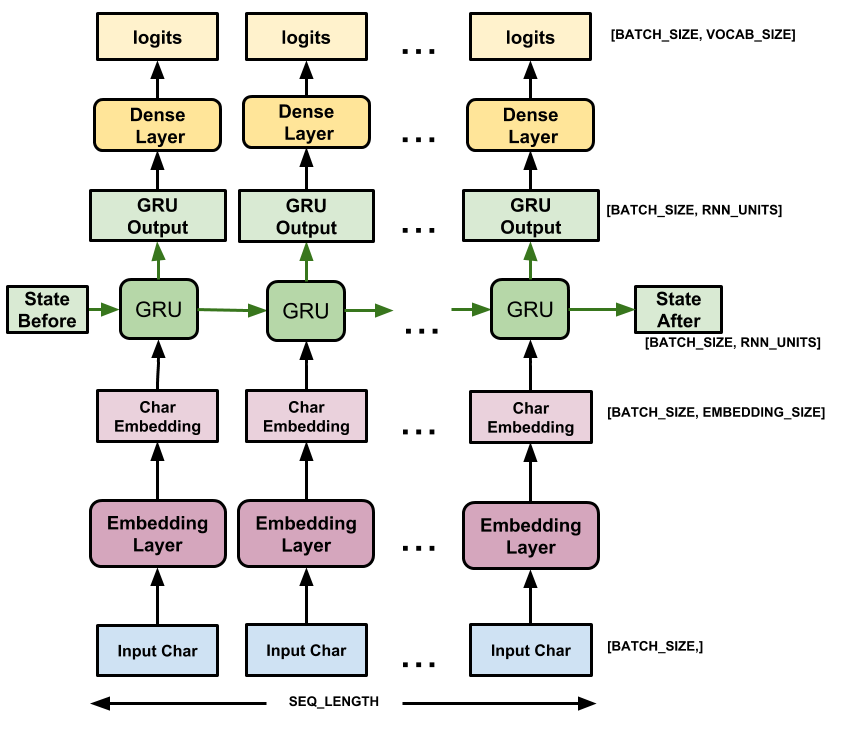

Примечание: Для обучения можно использовать вариант модели `keras.Sequential`. 

Чтобы сгенерировать текст позже, вам нужно будет управлять внутренним состоянием RNN. Проще заранее включить параметры ввода и вывода состояния, чем позже перестраивать архитектуру модели.

Подробнее см.[Гайд по реккурентным сетям](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

## Протестируем модель

Теперь запустим модель со случайными весами и скрытым состоянием, чтобы убедиться, что она ведет себя так, как ожидалось.

Сначала проверьте форму вывода:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


В приведенном выше примере длина последовательности входных данных равна `100` но модель может работать на входных данных любой длины

`64` - размерность 1 батча

`66` - сколько у нас символов + 1

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  0 (unused)
                                                                 
 lstm (LSTM)                 multiple                  5246976   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 5,331,522
Trainable params: 5,331,522
Non-trainable params: 0
_________________________________________________________________


Чтобы получить фактические прогнозы от модели, вам нужно сэмплировать по выборке из выходного распределения, чтобы получить фактические индексы символов. Это распределение определяется логитами по словарю символов.

Примечание. Важно _сэмплировать_ из распределения, так как использование _argmax_ по распределению может легко привести модель к зацикливанию.

В значит Вариативность



Попробуем  для первого примера в батче:

In [ ]:
example_batch_predictions[0]

<tf.Tensor: shape=(100, 66), dtype=float32, numpy=
array([[ 3.0169496e-05,  8.8263082e-04, -2.4501663e-03, ...,
         2.4906653e-03,  3.3725649e-03,  2.9997942e-03],
       [-5.7611503e-03, -8.8414428e-04, -4.9059819e-03, ...,
         2.5526900e-03, -1.5680460e-04,  1.8557871e-03],
       [-4.2379680e-03,  7.9100011e-03, -2.0427131e-03, ...,
         8.1503717e-03,  9.2000710e-03,  3.6193316e-03],
       ...,
       [-9.0220375e-03, -5.3261346e-03, -6.6717491e-03, ...,
         3.6721984e-03, -9.1494303e-03,  1.5363675e-03],
       [-6.5560918e-03, -7.7691460e-03, -9.8514436e-03, ...,
         4.1446341e-03, -5.6208922e-03,  1.0451432e-03],
       [-5.9202220e-03, -5.8798087e-03, -3.3637963e-03, ...,
         3.1547912e-03, -3.7415051e-03,  3.8200377e-03]], dtype=float32)>

Визуализируем

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('dark_background')

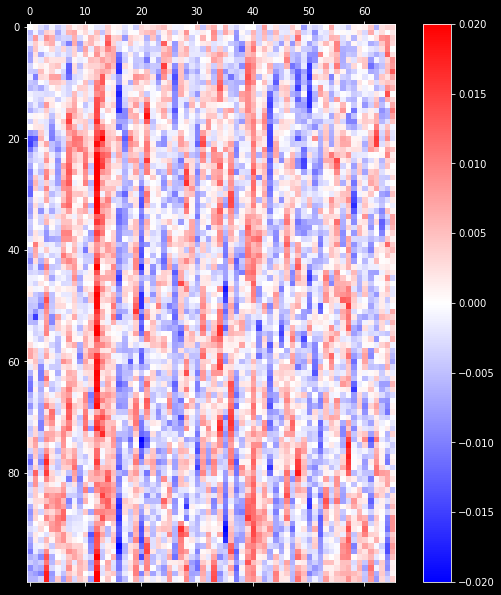

In [ ]:
fig = plt.figure(figsize = (10, 10))
plt.matshow(example_batch_predictions[0],
            cmap = 'bwr',vmin=-0.02,vmax=0.02, fignum=1)
plt.colorbar();

Очень красиво - но ничего не понятно

Посмотрим на вероятности для 1 символа

In [ ]:
x = example_batch_predictions[0][0]

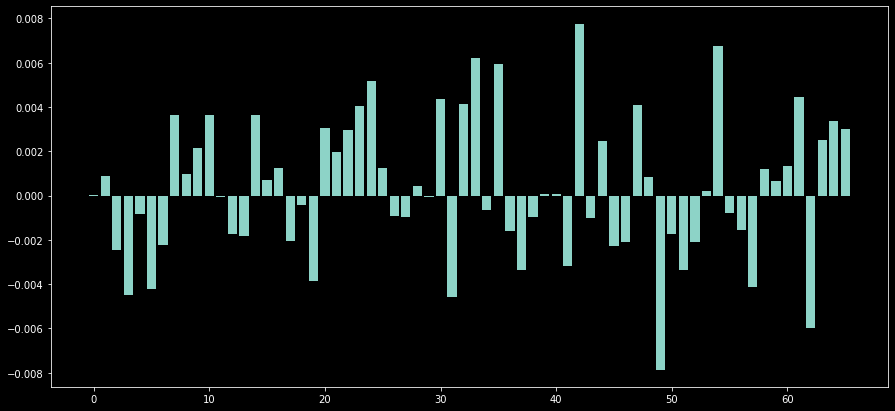

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.bar(np.arange(len(x)),x);

Делаем softmax от этого

In [ ]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

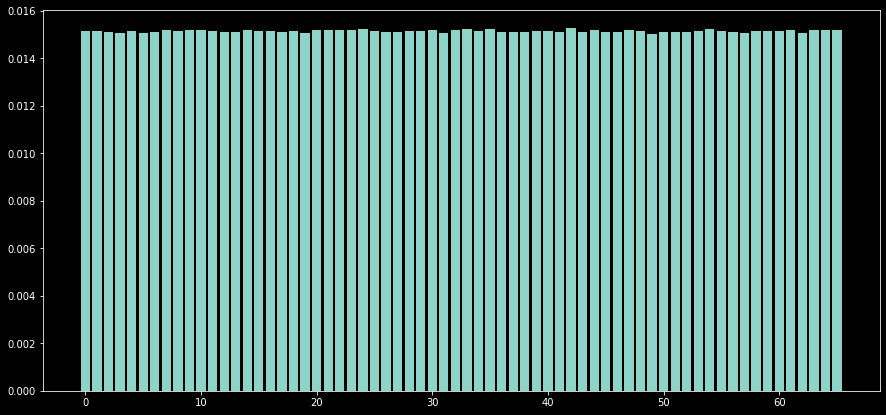

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.bar(np.arange(len(x)),softmax(x));

Логично 

Уверенности нет

Сплошной рандом

Поехали генерировать по этому распределению

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Это дает нам на каждом временном шаге прогноз индекса следующего символа:

In [ ]:
sampled_indices

array([41, 65,  8, 59, 14,  1, 21, 29,  9,  6, 31, 40, 64, 39, 23, 42, 50,
       40, 16, 53,  5, 28,  7, 35, 23, 33,  8, 47, 60, 51, 23, 64,  8, 62,
       64, 25, 46, 65, 54, 15, 10, 32, 50, 40, 33, 21,  3, 63, 14, 47,  7,
       28, 16, 56, 23, 35, 11, 34, 41, 60, 36, 12, 43, 21, 47, 20, 25, 38,
        9,  7, 52, 51, 55, 58, 52,  6, 19,  0, 27, 22, 58, 25, 37, 19, 25,
       22,  0, 60, 46, 64, 26, 20, 25, 26,  1, 44, 17, 31, 24,  1])

Декодируем, чтобы увидеть текст, предсказанный этой необученной моделью:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"cius was\nA worthy officer i' the war; but insolent,\nO'ercome with pride, ambitious past all thinking"

Next Char Predictions:
 b"bz-tA\nHP.'RayZJckaCn&O,VJT-hulJy-wyLgzoB3SkaTH!xAh,OCqJV:UbuW;dHhGLY.,mlpsm'F[UNK]NIsLXFLI[UNK]ugyMGLM\neDRK\n"


Кто бы мог предположить, что случайные веса необученной модели будут давать абсолютно случайный ответ?

## Обучаем Модель

На этом этапе задача может рассматриваться как стандартная задача классификации. 

Учитывая предыдущее состояние RNN и символ на этом временном шаге, предскажите вероятность следующего символа.

### Что-то там, оптимизаторы, что-то там функция потерь

Стандартная функция потерь `tf.keras.losses.sparse_categorical_crossentropy` работает в этом случае, потому что она применяется к последнему измерению прогнозов.

Поскольку наша модель возвращает логиты, нам необходимо установить флаг`from_logits`.


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.189952, shape=(), dtype=float32)


Просто инициализированная модель не должна быть слишком уверена в себе, все выходные логиты должны иметь одинаковые величины. Чтобы подтвердить это, вы можете проверить, что экспонента средней потери примерно равна размеру словаря. Гораздо более высокая потеря означает, что модель уверена в своих неправильных ответах и плохо инициализирована:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.019615

Настроем процедуру обучения с помощью метода `tf.keras.Model.compile` . 

Используем оптимизатор `tf.keras.optimizers.Adam` с параметрами по умолчанию и упомянутую выше функцию потерь

In [ ]:
model.compile(optimizer='adam', loss=loss)

### Добавляем Чекпоинты

Используем `tf.keras.callbacks.ModelCheckpoint` чтобы убедиться, что контрольные точки сохраняются во время обучения, а также `tf.keras.callbacks.EarlyStopping` остановиться раньше, до переобучения

In [ ]:
# Каталог, в котором будут сохранены контрольные точки
checkpoint_dir = './training_checkpoints'
# Имя файлов контрольных точек
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_best_only=True,
    monitor='loss', #в качестве альтернативы это может быть «val_loss», если у нас есть валидационные данные
    verbose=0,
    mode='min',
    save_weights_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',#в качестве альтернативы это может быть «val_loss», если у нас есть валидационные данные
    min_delta=0.01, #порог на изменение того, за чем мы мониторим
    patience=10, #сколько эпох "терпим"
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

### Запускаем обучение

Чтобы сохранить время обучения разумным, используйте 15 эпох для обучения модели. 

В Colab установите среду выполнения на GPU для более быстрого обучения.

In [ ]:
EPOCHS = 15

Жмем на кнопку и идём пить чай/писать отчет по проекту)

In [ ]:
history = model.fit(dataset, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback, early_stop])

Epoch 1/15
172/172 [==============================] - 14s 70ms/step - loss: 2.8240
Epoch 2/15
172/172 [==============================] - 13s 72ms/step - loss: 2.1073
Epoch 3/15
172/172 [==============================] - 13s 69ms/step - loss: 1.8372
Epoch 4/15
172/172 [==============================] - 13s 69ms/step - loss: 1.6662
Epoch 5/15
172/172 [==============================] - 13s 71ms/step - loss: 1.5544
Epoch 6/15
172/172 [==============================] - 13s 70ms/step - loss: 1.4774
Epoch 7/15
172/172 [==============================] - 13s 67ms/step - loss: 1.4208
Epoch 8/15
172/172 [==============================] - 13s 70ms/step - loss: 1.3770
Epoch 9/15
172/172 [==============================] - 13s 72ms/step - loss: 1.3405
Epoch 10/15
172/172 [==============================] - 13s 69ms/step - loss: 1.3089
Epoch 11/15
172/172 [==============================] - 13s 69ms/step - loss: 1.2804
Epoch 12/15
172/172 [==============================] - 13s 71ms/step - loss: 1.2533
E

Ну, он работает полных 15 эпох, но если мы поставим что-то вроде 50 эпох, он обязательно остановится заранее (но это не точно)

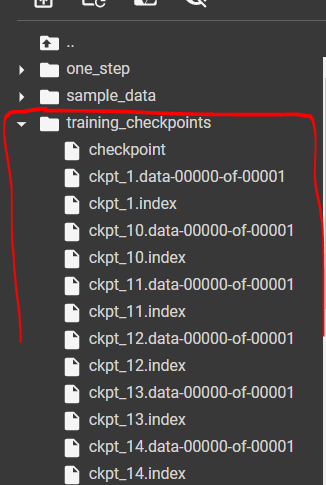

## Генерируем текст

Самый простой способ сгенерировать текст с помощью этой модели — запустить ее в цикле и отслеживать внутреннее состояние модели по мере ее выполнения.

Каждый раз, когда вы вызываете модель, вы передаете некоторый текст и внутреннее состояние. Модель возвращает прогноз для следующего символа и его нового состояния. Передайте предсказание и состояние обратно, чтобы продолжить создание текста.

Следующее делает одношаговый прогноз:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, 
               chars_from_ids, ids_from_chars, 
               temperature=1.0):
    super().__init__()
    self.temperature = temperature #Температура используется для корректировки прогноза. По простому, меньше - температура меньше случайного вывода
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Создим маску, чтобы предотвратить создание символа [UNK]
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Поместим -inf в каждый "плохой" индекс
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Сопоставьте форму со словарем
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Преобразование строк в идентификаторы токенов
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Запускаем модель
    # размерность predicted_logits [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Используем только последний прогноз
    predicted_logits = predicted_logits[:, -1, :]
    # Делаем поправку на температуру
    predicted_logits = predicted_logits/self.temperature
    # Применим маску предсказания: предотвратим создание «[UNK]»
    predicted_logits = predicted_logits + self.prediction_mask

    # Семплируем выходные логиты для создания идентификаторов маркеров.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Преобразование идентификаторов токенов в символы
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Возвращаем символы и скрытое состояние модели
    return predicted_chars, states

Про влияние температуры

Большая температура

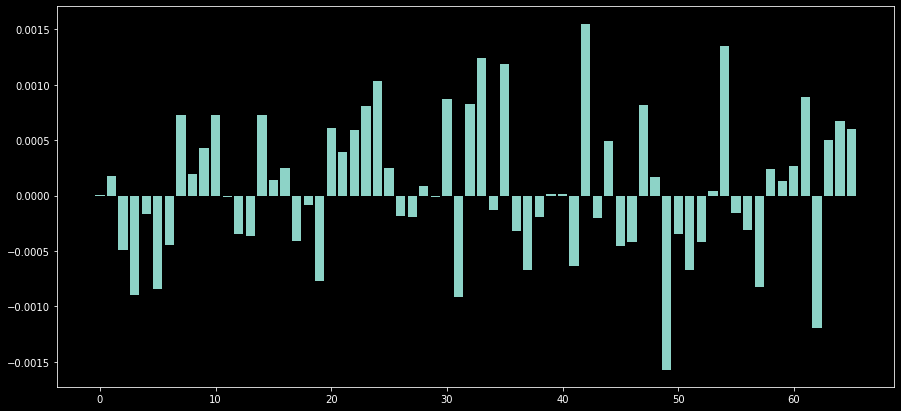

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.bar(np.arange(len(x)),x/5);

softmax от этого еще более плавный

и предсказание более рандомное

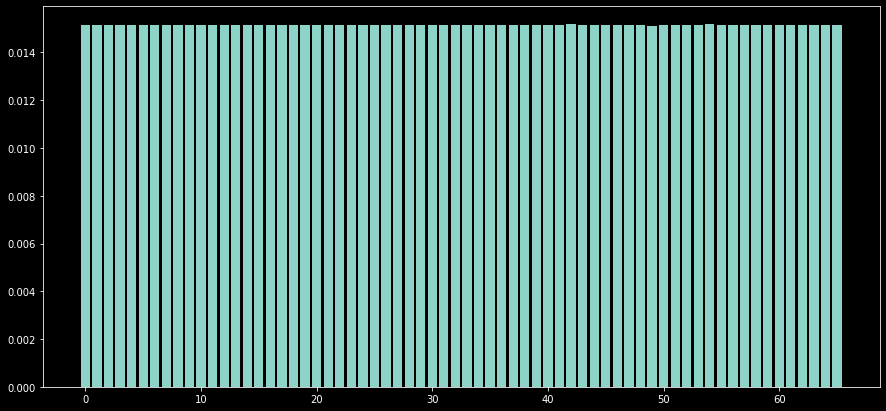

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.bar(np.arange(len(x)),softmax(x/5));

Про влияние температуры

Маленькая температура

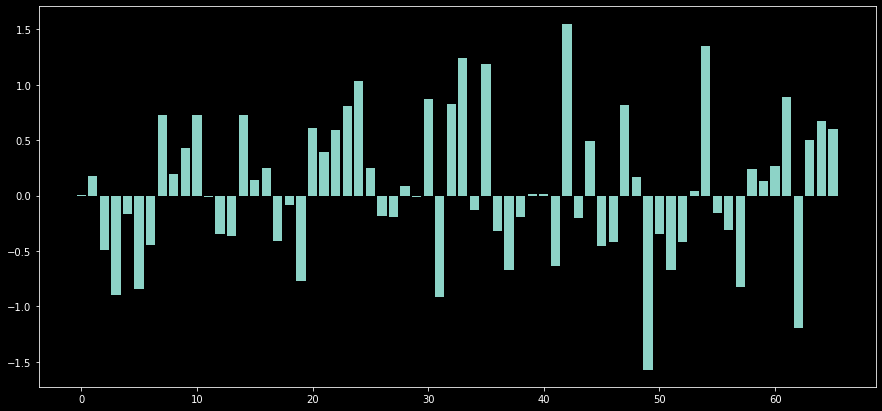

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.bar(np.arange(len(x)),x/0.005);

softmax уже выделяет любимчиков

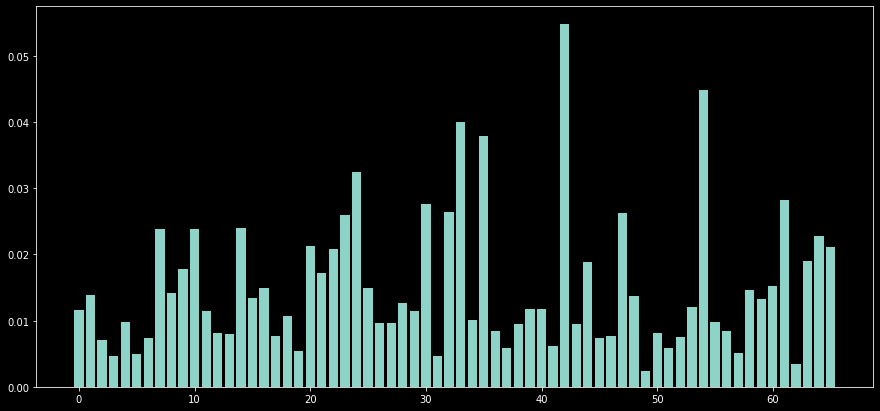

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.bar(np.arange(len(x)),softmax(x/0.005));

## Поехали генерировать текст

In [ ]:
one_step_model = OneStep(model, 
                         chars_from_ids, 
                         ids_from_chars)

Запускаем всё в цикле, чтобы сгенерировать текст. 

Глядя на сгенерированный текст, мы можем увидеть, что модель знает, когда использовать заглавные буквы, делать абзацы и имитирует шекспировский словарный запас. 

При малом числе эпох обучения он еще не научился составлять связные предложения.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:']) # не забудьте поменять стартовое слово
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80) #декодируем результат чтобы прочитать как есть
print('\nRun time:', end - start)

ROMEO:
Good propaghter, in two curses be so
noinger.

Shepherd:
Small him detended.

FRIAR LAURENCE:
Find shall with sweet Aufidius, silence! What has keep
And saw thy formacles; one follain's flus,
Your own by my counsel. nor ha, and foolish he,
Tybalt to be this sadness, if tyrant immedit
An 'Coming swear, in this unvillaoding sleets
Breaking her oncy of their high. By this, as our man;
I am my life, your soul, forthtright: he hath you spoke?

MONTAGUE:
Wherefore lay me? What Plutting his our due.
Your brother is thus never? that betten,
Marciesly, or ermonour, that nothing
Mates, do nothing power
Awake her fallen things unto my wife.

Provost:
You lay upon my silver than the woo,
Show from me hear out; and, extabling crosses;
Within Since, come, I'll tell me what you
are we may knle: but your deceit should let him
fall oa, making this point of boams. There's one!

EXMORSEL:

MERCUTIO:
No doubt: yet you are here,
My grandfither, God give my office and great
Assured in the consosing i

Самое простое, что вы можете сделать для улучшения результатов, — это тренироваться дольше (пробуем `EPOCHS = 30`).

Вы также можете поэкспериментировать с другой начальной строкой, попробовать добавить еще один слой RNN, чтобы повысить точность модели, или настроить параметр температуры, чтобы генерировать более или менее случайные прогнозы.

Если вы хотите, чтобы модель генерировала текст быстрее, самое простое, что вы можете сделать, это пакетное генерирование текста (паралельно)

В приведенном ниже примере модель генерирует 5 выходных данных примерно за то же время, что и выше.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:']) # можно задать несколько Разных стартовых слов
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80) # а тут не декодируем, иначе запутаемся где что (в сыром виде. А то он начнет переносить)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nNay, by himself, for death, I'll foll them sea\nWhat a more-biring thunder of your son\nWhat passage stars again,--women have Henry'd you.\n\nHENRY BOLINGBROKE:\nJast haste, ha! then, gentle shopest of many post,\nReturn'd in their own in hostess: yet hermione\nHas long cannot see the deputy till knoe\nHere's sight, Fall bless, and am I die, and therein\nall itself to persume truth: I pity my dead,\nI tell us their oldwards are made known\nAnd o'er from her accursed with from heavens,\nMy winds' breaks no longer, he had ever in\nsafety words.\n\nBRAKENBURY:\nWhy that\nShe king is here? thy liege, what, in proclamadioms,\nAre my though wail their robmestings,\nMy king and hostey's flightution, or ten\nthe cictors of him; him of all the losh,\nThat let them go.\n\nCORIOLANUS:\nO my soul, if you are device:\nYour mother do with us, and his mercy is brokes\nNo canity\nThe grace what haste a paced glarpa, and\nScorance.\n\nDUKE VINCENTIO:\nI am not with Bohemia: then f

## Сохраним Это все

На светлое будущее

Эта одношаговая модель может быть легко [сохранен и восстановлен](https://www.tensorflow.org/guide/saved_model),позволяет использовать его в любом месте где можно использовать `tf.saved_model`

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

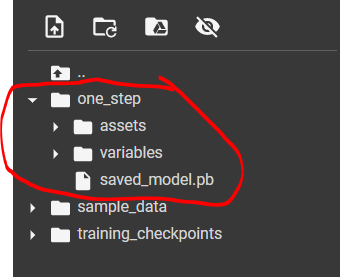

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Now weaves! why, there is such adonour-fuled
Nursel kind and terms us rashrant their heam
And stret


# Задание

1. Собрать свой текст (можно условного Льва Николаевича Толстого, можно подборку песен вашего любимого исполнителя. Главное чтобы было много букоф)

2. Можно немного пошаманить с настройками (длина последовательности, размерности слоя Embedding, сколько чего в RNN слое, тип слоя)

3. Обучить уверенную модель (накатив количество эпох)

4. Посмотреть что будет

5. Сравнить для разных значений температуры